### Importing Libraries
The first step in any Python script or Jupyter notebook is to import the necessary libraries. Here, we are importing libraries that will be used for stock data retrieval, risk portfolio analysis, time management, threading, and backtesting with the Zipline Reloaded framework.

In [27]:
import pandas as pd
import numpy as np

from zipline import run_algorithm
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume, CustomFactor, Returns
from zipline.api import (
    symbol,
    attach_pipeline,
    calendars,
    pipeline_output,
    date_rules,
    time_rules,
    get_datetime,
    set_commission,
    set_slippage,
    record,
    order_target_percent,
    get_open_orders,
    schedule_function,
    set_commission,
    set_slippage,
    set_benchmark
)
from zipline.finance import commission, slippage
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_full_tear_sheet
import warnings
warnings.filterwarnings("ignore")

### Trade settings
Instead of hard coding these settings inside the backtest, we'll make it easier on ourselves by setting them up front. In this case,set the number of long and short positions to take in our portfolio and the average dollar volume screener.

In [2]:
N_LONGS = N_SHORTS = 50
DOLLAR_VOLUME = 500

### The custom momentum factor
The class inherits from CustomFactor and specifies its inputs and the window length required for its computations. The inputs include the closing price of US equities (USEquityPricing.close) and the returns over a specified window length (126 trading days in this case). The window_length attribute is set to 252, which typically represents the number of trading days in a year. The compute method is where the core logic of the factor is implemented. This method is automatically called by Zipline with the necessary data aligned according to the specified inputs and window_length. The compute method calculates the momentum factor for each asset based on price changes over different periods: the change in price over the last 252 days (1 year) and the change over the last 21 days (1 month). This is then normalized by the standard deviation of returns over the specified period, to account for volatility. This normalization provides a relative measure of momentum, making it more comparable across different assets.

In [3]:
class MomentumFactor(CustomFactor):
    inputs = [USEquityPricing.close, Returns(window_length=126)]
    window_length = 252

    def compute(self, today, assets, out, prices, returns):
        out[:] = (
            (prices[-21] - prices[-252]) / prices[-252]
            - (prices[-1] - prices[-21]) / prices[-21]
        ) / np.nanstd(returns, axis=0)

### Create the Pipeline
A Pipeline is a framework that allows for the definition and efficient computation of a wide array of financial data over a set of assets. Within this pipeline, it incorporates a custom factor, MomentumFactor(), and a built-in factor, AverageDollarVolume(window_length=30). The pipeline is set up with four columns: "factor" holds the computed momentum values, "longs" and "shorts" represent the top and bottom assets based on momentum for a specified number of assets (N_LONGS and N_SHORTS), and "ranking" provides a rank of assets based on their momentum. We then use the built in AverageDollarVolume factor to set a screener to only include the top 500 assets by dollar volume.

In [4]:
def make_pipeline():
    momentum = MomentumFactor()
    dollar_volume = AverageDollarVolume(window_length=21)
    return Pipeline(
        columns={
            "factor": momentum,
            "longs": momentum.top(N_LONGS),
            "shorts": momentum.bottom(N_SHORTS),
            "ranking": momentum.rank(),
        },
        screen=dollar_volume.top(DOLLAR_VOLUME),
    )

### Recalculate the momentum factor
This function will be called before the trading day starts. It recalculate the factor values for each asset in the universe.

In [5]:
def before_trading_start(context, data):
    context.factor_data = pipeline_output("factor_pipeline")

### Initialize the backtest
The initialize function is run at the inception of the backtest. This is where we set up variables and execute calculations we want to use throughout the backtest. The context object is used to store state throughout the backtest. Here, we attach, or install, the Pipeline for use in the backtest. Then we schedule the rebalance function defined next to run at the market open every week on Monday. Finally, we set a commission and slippage model.

In [6]:
def initialize(context):
    attach_pipeline(make_pipeline(), "factor_pipeline")
    schedule_function(
        rebalance,
        date_rules.week_start(),
        time_rules.market_open(),
        calendar=calendars.US_EQUITIES,
    )
    
    # Set up the commission model to charge us per share and a volume slippage model
    set_commission(
        us_equities=commission.PerShare(
            cost=0.005,
            min_trade_cost=2.0
        )
    )
    set_slippage(
        us_equities=slippage.VolumeShareSlippage(
            volume_limit=0.0025, 
            price_impact=0.01
        )
    )
    set_benchmark(symbol("SPY"))

### Set our rebalance logic
In the initialize function, we scheduled the rebalance function to run. This is where the trade logic lives. First, we get DataFrame containing the factor data set in the before_trading_start function. We get the list of selected assets to trade the determine which assets to go long, which to go short, and which to divest. Then we run the exec_trades function on each list passing in the appropriate weights.

In [14]:
def rebalance(context, data):
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)

    assets = factor_data.index
    record(prices=data.current(assets, "price"))

    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))
    
    print(
        f"{get_datetime().date()} Longs: {len(longs)} Shorts: {len(shorts)} Value:{context.portfolio.portfolio_value}"
    )

    exec_trades(
        data, 
        assets=divest, 
        target_percent=0
    )
    exec_trades(
        data, 
        assets=longs, 
        target_percent=1 / N_LONGS
    )
    exec_trades(
        data, 
        assets=shorts, 
        target_percent=-1 / N_SHORTS
    )

### Execute the trades
We loop through every asset, determine if it's tradeable and there are no open orders. Then we order the target percent and Zipline rebalances our portfolio for us.

In [15]:
def exec_trades(data, assets, target_percent):
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

### Analyze the results
We can ask Zipline to run a function at the conclusion of the backtest. In this case, we simply print the equity curve.

In [16]:
def analyze(context, perf):
    perf.portfolio_value.plot()

### Run the backtest
The run_algorithm funtion kicks off the backtest. It takes the start and end date, the initialize function that runs at the inception of the backtest, the analyze function that runs at the conclusion of the backtest, the capital to start the backtest with, and the name of the bundle.

In [31]:
perf = run_algorithm(
    start=pd.Timestamp("2018-01-01"),
    end=pd.Timestamp("2023-12-31"),
    initialize=initialize,
    before_trading_start=before_trading_start,
    capital_base=100_000,
    bundle="quotemedia",
)

2018-01-02 Longs: 9 Shorts: 6 Value:100000.0
2018-01-08 Longs: 5 Shorts: 3 Value:101043.35999995928
2018-01-16 Longs: 7 Shorts: 5 Value:101338.13999989216
2018-01-22 Longs: 6 Shorts: 5 Value:102422.05999988757
2018-01-29 Longs: 4 Shorts: 6 Value:100234.75999985344
2018-02-05 Longs: 3 Shorts: 4 Value:97552.23999984526
2018-02-12 Longs: 3 Shorts: 8 Value:98223.09999983523
2018-02-20 Longs: 7 Shorts: 9 Value:99522.51999981276
2018-02-26 Longs: 4 Shorts: 9 Value:101816.88999979905
2018-03-05 Longs: 4 Shorts: 9 Value:99972.34999979466
2018-03-12 Longs: 5 Shorts: 1 Value:101562.72999979208
2018-03-19 Longs: 10 Shorts: 1 Value:101107.72999973378
2018-03-26 Longs: 8 Shorts: 6 Value:100806.52999971237
2018-04-02 Longs: 10 Shorts: 3 Value:99273.14999969845
2018-04-09 Longs: 8 Shorts: 6 Value:99964.9099996886
2018-04-16 Longs: 7 Shorts: 5 Value:101363.27999964888
2018-04-23 Longs: 7 Shorts: 3 Value:101397.34999964703
2018-04-30 Longs: 8 Shorts: 4 Value:101027.97999963062
2018-05-07 Longs: 8 Short

2020-11-23 Longs: 14 Shorts: 2 Value:100477.4599953726
2020-11-30 Longs: 11 Shorts: 1 Value:100639.54999536116
2020-12-07 Longs: 13 Shorts: 2 Value:100912.34999535474
2020-12-14 Longs: 15 Shorts: 1 Value:101113.51299534578
2020-12-21 Longs: 15 Shorts: 1 Value:102901.80599532662
2020-12-28 Longs: 14 Shorts: 1 Value:101736.53599532365
2021-01-04 Longs: 14 Shorts: 1 Value:102642.41399531049
2021-01-11 Longs: 11 Shorts: 1 Value:105332.65399528288
2021-01-19 Longs: 12 Shorts: 4 Value:106339.4689952675
2021-01-25 Longs: 13 Shorts: 2 Value:106136.65099524704
2021-02-01 Longs: 11 Shorts: 4 Value:105985.99099523375
2021-02-08 Longs: 11 Shorts: 3 Value:107792.47599515578
2021-02-16 Longs: 12 Shorts: 0 Value:108459.65099512166
2021-02-22 Longs: 12 Shorts: 1 Value:106545.32099510964
2021-03-01 Longs: 9 Shorts: 1 Value:106192.74099510763
2021-03-08 Longs: 11 Shorts: 4 Value:100751.57099509894
2021-03-15 Longs: 14 Shorts: 5 Value:105941.10596667383
2021-03-22 Longs: 10 Shorts: 5 Value:103767.9008701

2023-10-09 Longs: 1 Shorts: 0 Value:106741.17086441984
2023-10-16 Longs: 1 Shorts: 0 Value:106778.6508644144
2023-10-23 Longs: 0 Shorts: 1 Value:106816.8708644144
2023-10-30 Longs: 0 Shorts: 1 Value:107027.9958643081
2023-11-06 Longs: 0 Shorts: 1 Value:107482.17586429778
2023-11-13 Longs: 0 Shorts: 0 Value:107236.20586427991
2023-11-20 Longs: 0 Shorts: 0 Value:107419.85086249503
2023-11-27 Longs: 0 Shorts: 0 Value:107419.85086249503
2023-12-04 Longs: 0 Shorts: 0 Value:107419.85086249503
2023-12-11 Longs: 0 Shorts: 0 Value:107419.85086249503
2023-12-18 Longs: 0 Shorts: 0 Value:107419.85086249503
2023-12-26 Longs: 0 Shorts: 0 Value:107419.85086249503


### Cache the performance output
Since perf is a DataFrame, we can use the pandas to_pickle method to serialize the performance output.

In [ ]:
perf.to_pickle("momentum-factor.pickle")

Then later, we can read it...

In [41]:
perf = pd.read_pickle("risk-parity.pickle")

### Prepare the DataFrames for Alphalens
We need to do some basic pandas manipulation of the performance DataFrame to extract the historic prices and factor data from our backtest. Construct a DataFrame called prices where each column represents a symbol and each row represents a date. We do this by iterating through each row of prices using the items method which returns an iterator. Each key is the date and each value is a DataFrame representing price data. Each of these DataFrames is converted to a column with the date as the column's name using the to_frame method. The concat function then concatenates these columns horizontally using the axis=1 argument.

In [32]:
prices = pd.concat(
    [df.to_frame(d) for d, df in perf.prices.dropna().items()], 
    axis=1
).T
prices.columns = [col.symbol for col in prices.columns]
prices.index = prices.index.normalize()

In [33]:
prices

,AA,AABA,AAL,AAP,AAPL,ABBV,ABC,ABT,ABX,ACN,...,HUBB,TPST,WSO,DUOL,IMGN,CNHI,CG,CLSK,CCEP,CERE
2018-01-02 00:00:00+00:00,55.17,73.13,52.99,106.09,172.26,98.41,94.04,58.79,15.20,153.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 00:00:00+00:00,55.17,73.13,52.99,106.09,172.26,98.41,94.04,58.79,15.20,153.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04 00:00:00+00:00,55.17,73.13,52.99,106.09,172.26,98.41,94.04,58.79,15.20,153.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05 00:00:00+00:00,55.17,73.13,52.99,106.09,172.26,98.41,94.04,58.79,15.20,153.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08 00:00:00+00:00,55.00,76.48,52.13,111.39,174.35,99.49,96.90,58.82,14.74,158.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00+00:00,NaN,NaN,14.24,NaN,195.89,153.42,NaN,108.06,NaN,341.85,...,NaN,NaN,NaN,NaN,29.47,11.60,41.79,10.84,NaN,NaN
2023-12-26 00:00:00+00:00,NaN,NaN,14.11,NaN,193.05,154.62,NaN,109.23,NaN,353.43,...,NaN,NaN,NaN,NaN,29.85,12.03,40.88,11.74,66.17,42.31
2023-12-27 00:00:00+00:00,NaN,NaN,14.11,NaN,193.05,154.62,NaN,109.23,NaN,353.43,...,NaN,NaN,NaN,NaN,29.85,12.03,40.88,11.74,66.17,42.31
2023-12-28 00:00:00+00:00,NaN,NaN,14.11,NaN,193.05,154.62,NaN,109.23,NaN,353.43,...,NaN,NaN,NaN,NaN,29.85,12.03,40.88,11.74,66.17,42.31


To extract the factor data from the backtest output, we follow similar steps. First we iterate through factor_data column dropping any null values, and reshaping the data so that each date corresponds to a unique column. Next, we convert the column names to strings and adjust the dates like before. Finally, the DataFrame is transformed from a two-dimensional table into a one-dimensional series with a hierarchical index. We do this with the stack method, resulting in a multi-indexed Series where the primary level of the index is the date and the secondary level is the symbol. For clarity, these levels are named "date" and "asset."

In [34]:
factor_data = pd.concat(
    [df.to_frame(d) for d, df in perf.factor_data.dropna().items()], axis=1
).T
factor_data.columns = [col.symbol for col in factor_data.columns]
factor_data.index = factor_data.index.normalize()
factor_data = factor_data.stack()
factor_data.index.names = ["date", "asset"]

In [35]:
factor_data

date                       asset
2018-01-02 00:00:00+00:00  AA       3852.0
                           AABA     7654.0
                           AAL      3166.0
                           AAP       645.0
                           AAPL     7707.0
                                     ...  
2023-12-29 00:00:00+00:00  CNHI     1731.0
                           CG       2852.0
                           CLSK     6666.0
                           CCEP     6170.0
                           CERE      314.0
Length: 740604, dtype: float64

### Compute forward returns and quantiles
Now that the DataFrames are prepared, we can call the AlphaLens get_clean_factor_and_forward_returns function. The purpose of this function is to associate factor values with future returns. The output, stored in the variable alphalens_data, is a DataFrame that combines the factor data with the subsequent returns based on the provided prices. This merged structure allows us to analyze how specific factor values might have influenced or related to future asset returns.

In [42]:
alphalens_data = get_clean_factor_and_forward_returns(
    factor=factor_data, 
    prices=prices, 
    periods=(5, 10, 21, 63), 
    quantiles=5
)

Dropped 4.2% entries from factor data: 4.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


The resulting DataFrame has a MultiIndex with dates and symbols. The columns in the DataFrame represent different forward returns (5D, 10D, 21D, and 63D for 5-day, 10-day, 21-day, and 63-day returns), the factor values and quantile rankings of the factor values. The quantile rankings segment the factor values into groups, with the shown values like "3" or "5" indicating the specific quantile bucket the factor value for an asset falls into on a given date.

In [39]:
alphalens_data

5D       10D       21D       63D  factor  factor_quantile
date                      asset                                                                 
2018-01-02 00:00:00+00:00 AA    -0.003081  0.019395 -0.012326 -0.196302  3852.0                2
                          AABA   0.045809  0.010803  0.084917 -0.020922  7654.0                5
                          AAL   -0.016229  0.094169 -0.005850 -0.060577  3166.0                2
                          AAP    0.049958  0.073617  0.158356  0.092186   645.0                1
                          AAPL   0.012133  0.022814 -0.024962 -0.032393  7707.0                5
...                                   ...       ...       ...       ...     ...              ...
2023-09-29 00:00:00+00:00 CRH   -0.040816  0.008518 -0.050754  0.222005  9318.0                5
                          GLPI  -0.033778  0.003227  0.003227  0.003227  3968.0                2
                          FNF   -0.051400 -0.049952 -0.049952 -0.049952  5373.0                2
                          TWNK   0.000000 -0.008388 -0.008388 -0.008388   125.0                1
                          WFRD  -0.000883 -0.000883 -0.000883 -0.000883  8943.0                5

[709313 rows x 6 columns]

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,4006.0,1544.467744,842.617422,142469,20.085491
2,1428.0,5991.0,3764.552916,791.801801,141564,19.957903
3,3407.0,7718.0,5541.143870,774.074702,141551,19.956070
4,4798.0,9088.0,7022.684305,725.553608,141564,19.957903
5,6580.0,10350.0,8212.468301,742.945445,142165,20.042633


Returns Analysis


,5D,10D,21D,63D
Ann. alpha,-0.016,-0.020,-0.031,-0.028
beta,0.040,0.017,0.023,-0.040
Mean Period Wise Return Top Quantile (bps),-9.494,-7.161,-8.374,-10.112
Mean Period Wise Return Bottom Quantile (bps),7.960,9.639,10.357,8.141
Mean Period Wise Spread (bps),-17.454,-16.457,-18.234,-18.073


<Figure size 640x480 with 0 Axes>

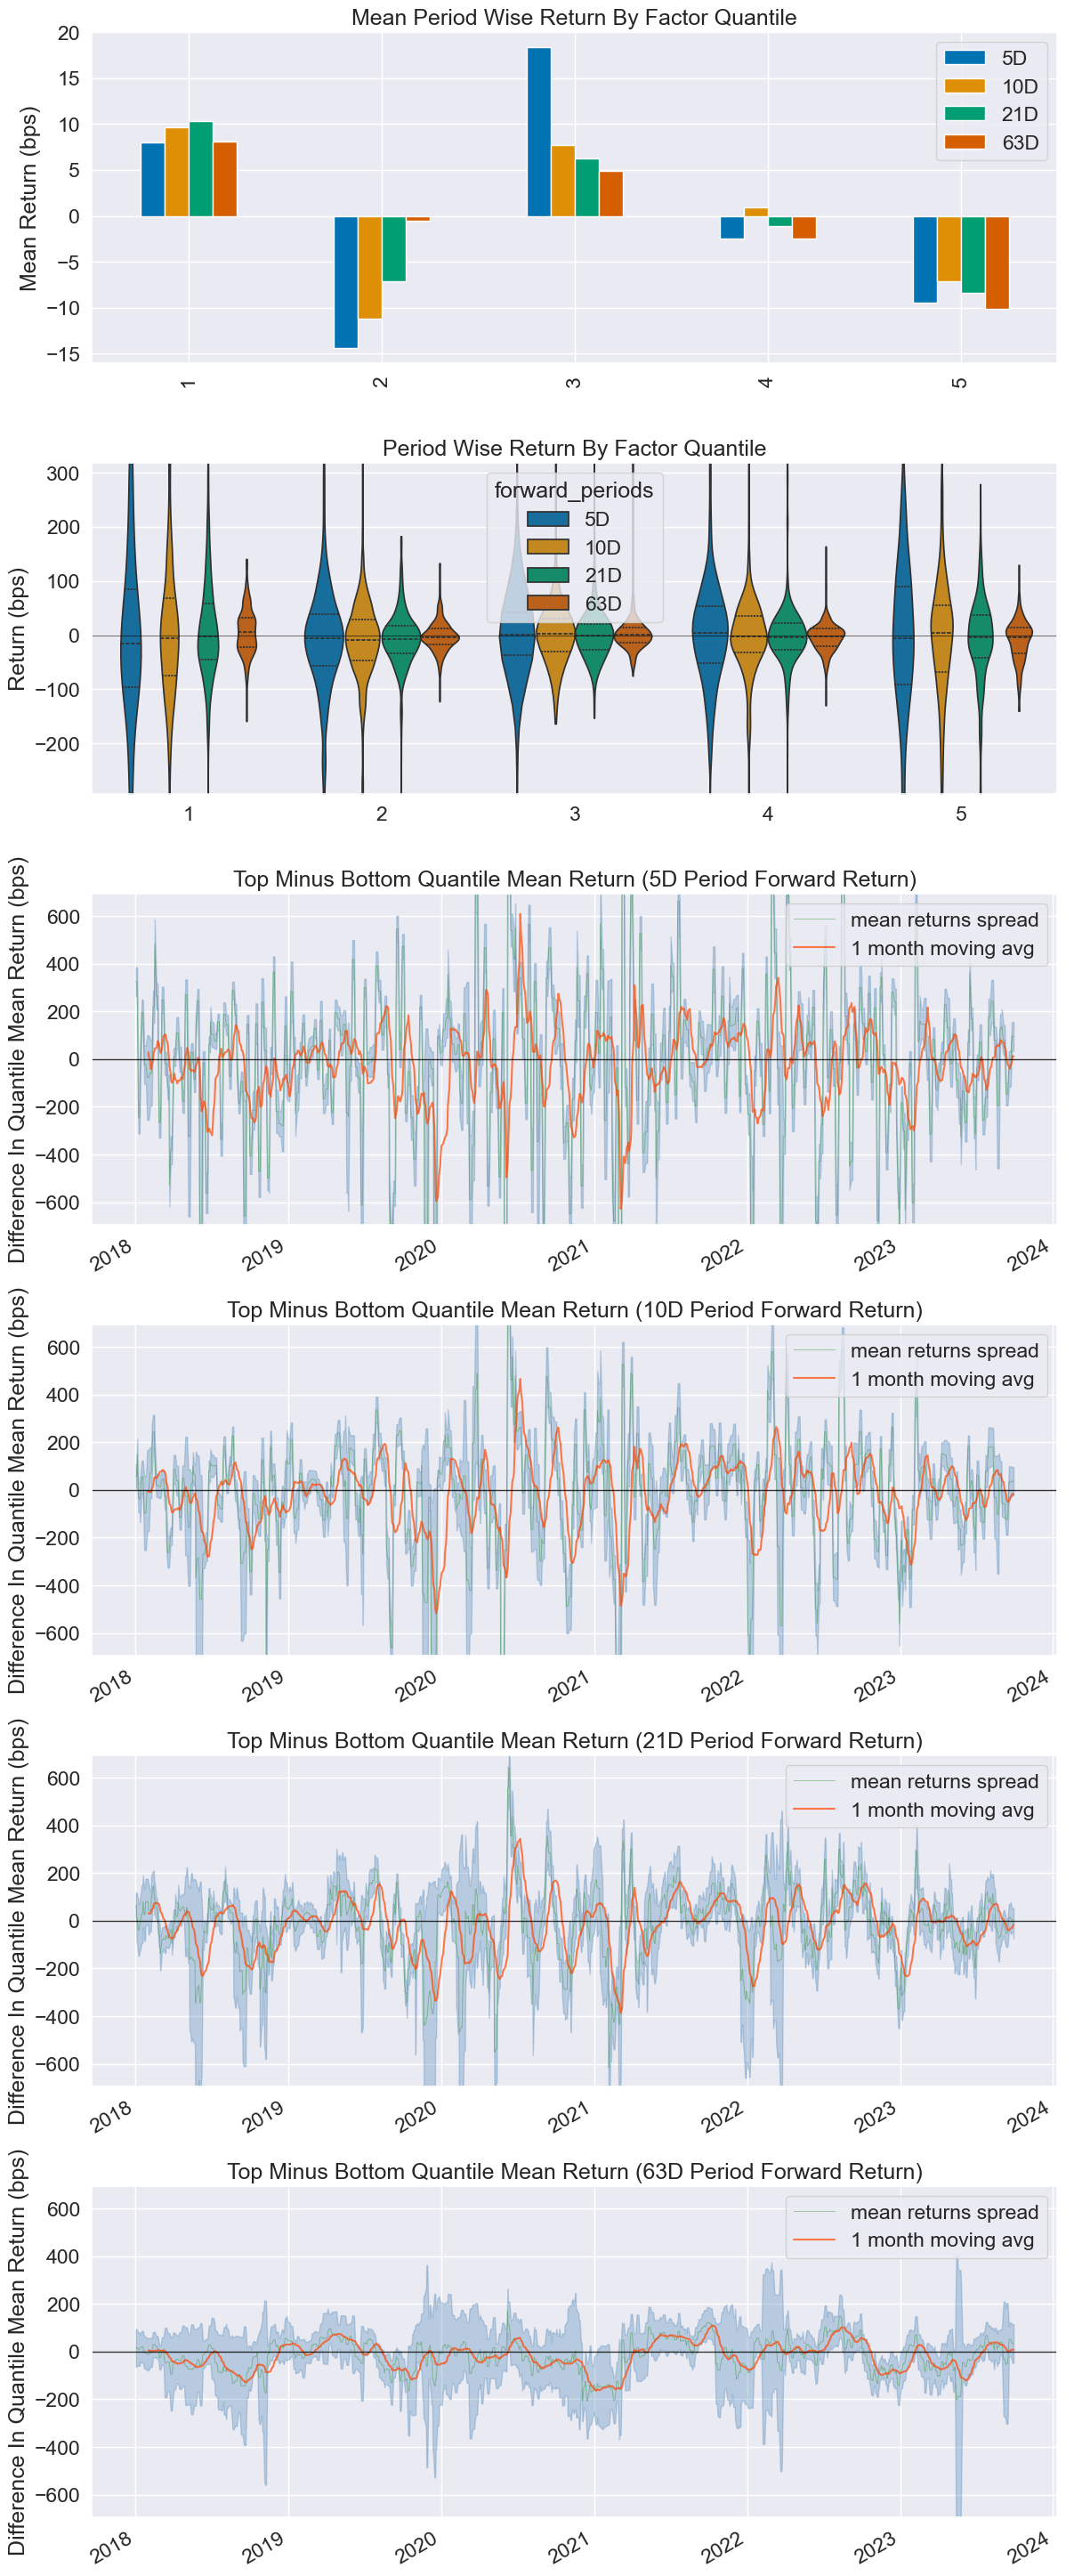

Information Analysis


,5D,10D,21D,63D
IC Mean,0.023,0.022,0.020,0.007
IC Std.,0.220,0.208,0.196,0.186
Risk-Adjusted IC,0.105,0.107,0.101,0.039
t-stat(IC),3.987,4.071,3.834,1.480
p-value(IC),0.000,0.000,0.000,0.139
IC Skew,-0.083,-0.097,-0.092,-0.277
IC Kurtosis,0.042,0.148,0.289,-0.533


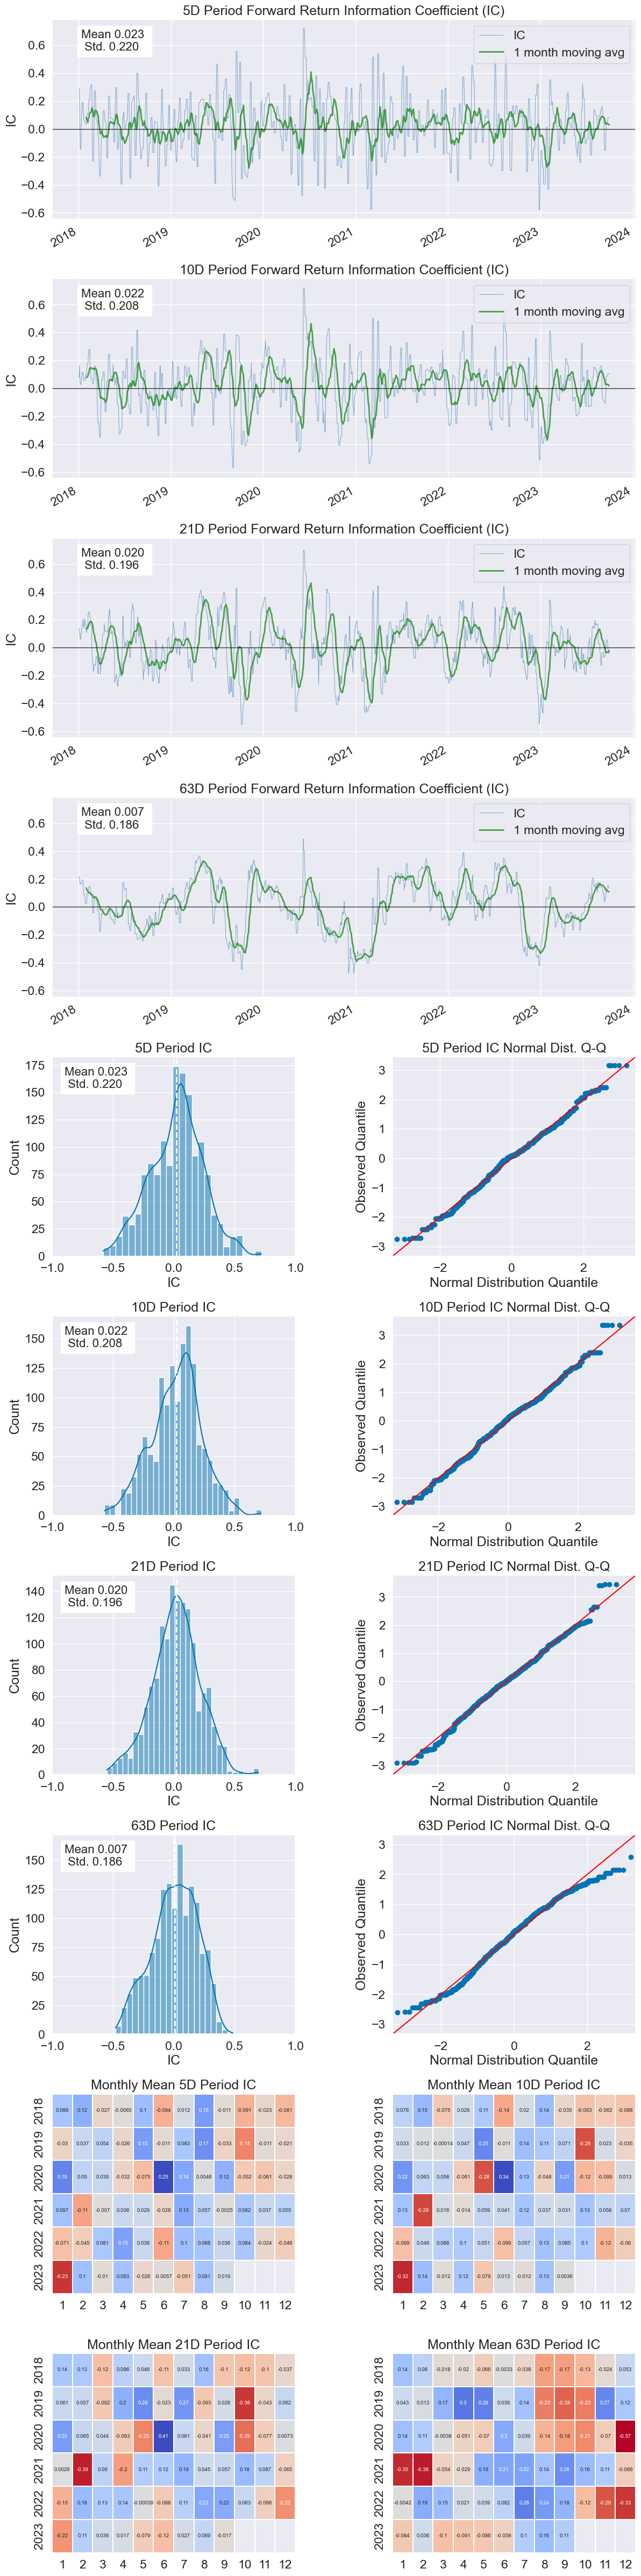

Turnover Analysis


,5D,10D,21D,63D
Quantile 1 Mean Turnover,0.237,0.340,0.491,0.591
Quantile 2 Mean Turnover,0.423,0.545,0.662,0.739
Quantile 3 Mean Turnover,0.458,0.578,0.690,0.765
Quantile 4 Mean Turnover,0.414,0.535,0.658,0.752
Quantile 5 Mean Turnover,0.211,0.301,0.430,0.577


,5D,10D,21D,63D
Mean Factor Rank Autocorrelation,0.924,0.856,0.725,0.569


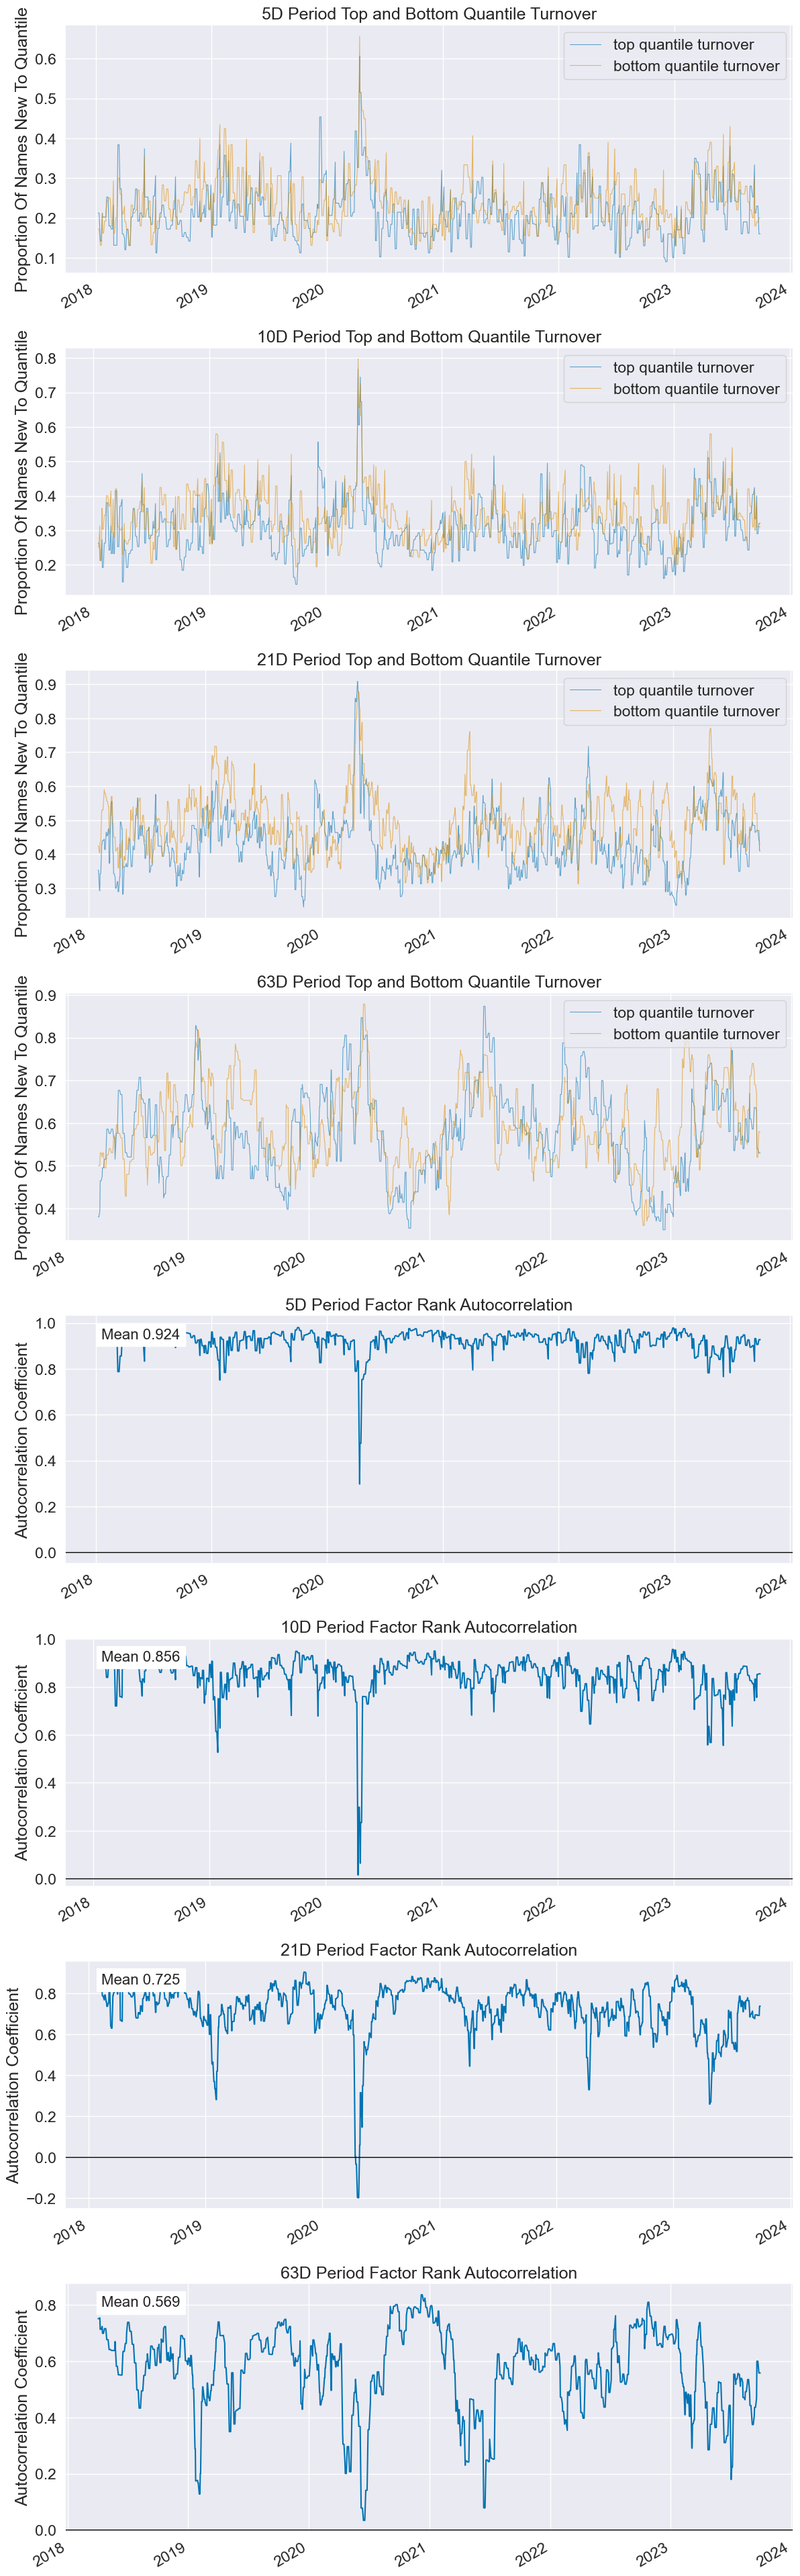

In [40]:
create_full_tear_sheet(alphalens_data)

### Notes on autocorrelation of factors:

A high positive autocorrelation in a momentum factor might be seen as favorable in a momentum-based strategy, indicating that the factor reliably identifies assets with sustained momentum.

#### Autocorrelation Value Range:

* The autocorrelation values will range between -1 and 1.
* A value of 1 implies perfect positive autocorrelation, meaning the ranking of factors remains exactly the same from one period to the next.
* A value of -1 implies perfect negative autocorrelation, indicating a complete inversion of rankings between periods.
* A value of 0 suggests no autocorrelation, implying that the rankings in one period provide no information about the rankings in the next period.

#### Interpreting Positive Autocorrelation:

* Positive values (closer to 1) indicate that the ranks of the factors are consistent over the specified period. For example, if a factor ranks assets highly in one period, it tends to rank them highly in the next period as well.
* This consistency suggests stability in the factor's ability to rank assets, which might be desirable in certain investment strategies.

#### Interpreting Negative Autocorrelation:

* Negative values (closer to -1) suggest that the factor rankings are inversely related from one period to the next. For instance, assets ranked highly in one period are likely to be ranked lower in the subsequent period.
* This might indicate a reversal pattern in the factor's ranking mechanism, which could be useful in strategies that aim to capitalize on such reversals.

#### Interpreting Values Near Zero:

* Values near zero imply that the rankings in one period have little to no correlation with the rankings in the following period.
* This could suggest randomness in the factor's ranking, indicating that it might not be a reliable metric for predicting future rankings.